In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pickle
from backgammon import *
from elements import *
from tqdm import tqdm
from ai_strategies import *
import random

def softmax(s):
    num = [np.exp(s[i])+0.00001 for i in range(len(s))]
    return [x/sum(num) for x in num]

def eval_deriv(k, f, cl, probs):
    res = f[k]
    if k == cl:
        res*=-(1-probs[cl])
    else:
        res*=probs[cl]
    return res

def cross(l1, l2):
    for i in range(len(l1)):
        r+=l1[i]*l[2]
        

def save_game(game):
    tosave = []
    g = Game()
    if game['win'] == 0:
        cond = 1
    else:
        cond = 0
    for i,p in enumerate(game['plays']):
        t = Turn(p[0], Roll(list(p[1])))
        poss_moves = g.board.get_pairs_moves(t)
        if any(list(x) in poss_moves for x in itertools.permutations(p[2]))==False and not (p[2]==poss_moves):
            if len(game['plays'])-1 == i:
                return tosave
            return 
        if i%2 == cond and len(poss_moves)>0:
            for j, ms in enumerate(poss_moves):
                if any(list(x) == ms for x in itertools.permutations(p[2])):
                    cl = j
            tosave.append((g.board, t, poss_moves, cl, p[2]))
        for m in p[2]:
            g.board = g.board.move(t.player, *m)
    return tosave

In [ ]:
with open('data/process/norges.pkl', 'r') as f:
    games = pickle.load(f)

In [ ]:
with open('data/process/gnu_vs_blitz.pkl', 'r') as f:
    games2 = pickle.load(f)

In [ ]:
with open('data/process/200_7_pts.pkl', 'r') as f:
    games3 = pickle.load(f)

In [ ]:
with open('data/process/100_5_pts.pkl', 'r') as f:
    games_test = pickle.load(f)

In [ ]:
games += games2
games += games3

In [ ]:
random.shuffle(games)

In [ ]:
saved_games = []
for game in tqdm(games):
    try:
        saved_games.extend(save_game(game))
    except:
        pass

In [ ]:
with open('data/saved_games.pkl', 'w') as f:
    pickle.dump(saved_games, f)

In [4]:
with open('data/saved_games.pkl', 'r') as f:
    saved_games = pickle.load(f)

In [ ]:
def test(game, w):
    g = Game()
    pos = 0
    c = 0
    if game['win'] == 0:
        cond = 1
    else:
        cond = 0
    for i,p in enumerate(game['plays']):
        t = Turn(p[0], Roll(list(p[1])))
        poss_moves = g.board.get_pairs_moves(t)
        if any(list(x) in poss_moves for x in itertools.permutations(p[2]))==False and not (p[2]==poss_moves):
            if len(game['plays'])-1 == i:
                return w, L/(len(game['plays'])-1)
#             print 'ERROR: MOVE MADE NOT POSSIBLE'
            return 
        if i%2 == cond and len(poss_moves)>0:
            c+=1
            probs = []
            for j, ms in enumerate(poss_moves):
                temp = g.board.copy()
                for m in ms:
                    temp = temp.move(t.player, *m)
                f = temp.get_features(g.board, t.player)
                if any(list(x) == ms for x in itertools.permutations(p[2])):
                    f_j = f
                    cl = j
                probs.append(score(w, f))
            if max(probs) == probs[cl]:
                pos+=1   
        for m in p[2]:
            g.board = g.board.move(t.player, *m)
    return pos, c

In [56]:
def train(plays, w, l=0.01, lam=0):
    L = []
    for p in tqdm(plays):
        board, t, poss_moves, cl, moves = p
        if len(poss_moves)<=1:
            continue
        probs = []
        for j, ms in enumerate(poss_moves):
            temp = board.copy()
            for m in ms:
                temp = temp.move(t.player, *m)
            f = temp.feat(board, t.player)
            if j == cl:
                f_j = f
            probs.append(score(w, f))
        probs = softmax(probs)
        L.append(np.log(probs[cl]))
        w_copy = w.asList[:]
        for k in range(len(w_copy)):
            w_copy[k] -= l*(eval_deriv(k, f_j, cl, probs)+lam*w_copy[k])
        w.asList = w_copy
    return w, L
def train2(plays, w, l=0.01, lam=0):
    L = []
    for p in tqdm(plays):
        board, t, poss_moves, cl, moves = p
        if len(poss_moves)<=1:
            continue
        probs = []
        fs = []
        for j, ms in enumerate(poss_moves):
            temp = board.copy()
            for m in ms:
                temp = temp.move(t.player, *m)
            f = temp.feat(board, t.player)
            fs.append(f)
            if j == cl:
                f_j = f
            probs.append(score(w, f))
        probs = softmax(probs)
        w_copy = w.asList[:]
        for k in len(w_copy):
            w_copy[k] += l*(f_j[k] - sum([probs[j]*fs[j][k] for k in range(len(probs))])-lam*w_copy[k])
        w.asList = w_copy
    return w, L

In [87]:
def test(plays, w):
    pos = 0 
    c = 0
    for p in tqdm(plays):
        board, t, poss_moves, cl, moves = p
        if len(poss_moves)<=1:
            continue
        c+=1
        probs = []
        for j, ms in enumerate(poss_moves):
            temp = board.copy()
            for m in ms:
                temp = temp.move(t.player, *m)
            f = temp.feat(board, t.player)
            if j == cl:
                f_j = f
            probs.append(score(w, f))
        probs = softmax(probs)
        if probs[cl] == max(probs): 
            pos+=1
    return float(pos)/c

In [61]:
mini_train_data = saved_games[:int(0.25*len(saved_games))]
train_data = saved_games[:int(0.9*len(saved_games))]
test_data = saved_games[int(0.9*len(saved_games)):]

In [72]:
w = SimpleWeights(np.random.normal(scale=.1, size=21), 'test')
print w
L = []
av_L = []
acc = []

test: [ 0.09559969 -0.11419075  0.12268652  0.00473283 -0.12432153  0.00625329
  0.06294914 -0.1222899   0.142476    0.0817114  -0.16369798  0.01096698
 -0.23348222  0.10540505 -0.13214728  0.03503387 -0.13402459 -0.04979529
 -0.09459473 -0.13644621  0.04989337]


In [81]:
for i in range(1):
    w, l = train(saved_games[:int(0.2*len(saved_games))], w, 0.01, 0.01)
    L.append(l)
    av_L.append(sum(l)/len(l))
    acc.append(test(saved_games[int(0.2*len(saved_games)):int(0.2*len(saved_games))+1000], w))

100%|██████████| 1000/1000 [00:22<00:00, 44.94it/s]


In [83]:
acc

[0.5334846765039728,
 0.6095346197502838,
 0.6129398410896708,
 0.6220204313280363,
 0.6254256526674233,
 0.6299659477866061,
 0.6333711691259932]

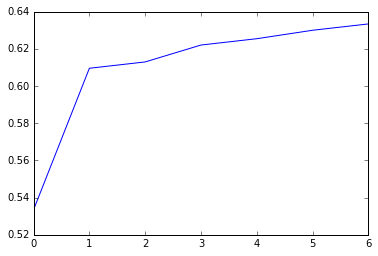

In [82]:
plt.plot(acc)

In [78]:
w_ = w.asList[:]

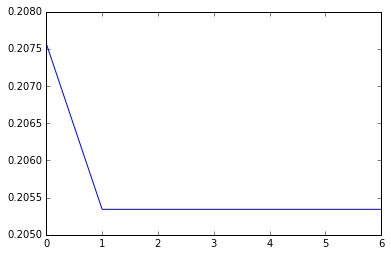

In [71]:
plt.plot(acc)

In [86]:
test(saved_games[:int(0.1*len(saved_games))], aggressive)

100%|██████████| 2676/2676 [00:47<00:00, 56.26it/s]


0.28619670747150694

In [88]:
w2 = SimpleWeights(np.random.normal(scale=.5, size=21), 'test')
L2 = []
av_L2 = []
acc2 = []

for i in range(5):
    w2, l2 = train(train_data, w2, 0.001, 0.01)
    L2.append(l2)
    av_L2.append(sum(l2)/len(l2))
    acc2.append(test(test_data, w2))

100%|██████████| 2677/2677 [00:48<00:00, 55.13it/s]


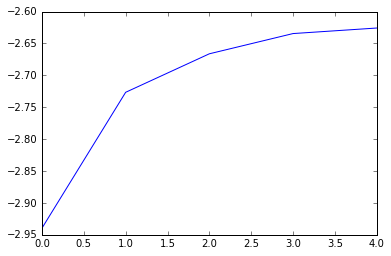

In [91]:
plt.plot(av_L2)

In [92]:
w3 = SimpleWeights(w2.asList, 'test')
L3 = []
av_L3 = []
acc3 = []
for i in range(3):
    w3, l3 = train(train_data, w3, 0.001, 0.01)
    L3.append(l3)
    av_L3.append(sum(l3)/len(l3))
    acc3.append(test(test_data, w3))

100%|██████████| 2677/2677 [00:52<00:00, 51.43it/s]


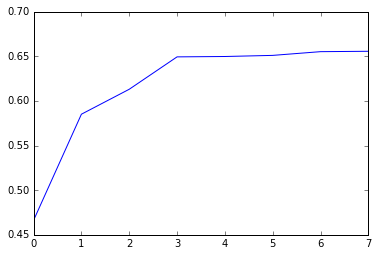

In [94]:
plt.plot(acc2+acc3)

In [95]:
w4 = SimpleWeights(w2.asList, 'test')
L4 = []
av_L4 = []
acc4 = []
for i in range(3):
    w4, l4 = train(train_data, w4, 0.01, 0.01)
    L4.append(l4)
    av_L4.append(sum(l4)/len(l4))
    acc4.append(test(test_data, w4))

100%|██████████| 2677/2677 [00:54<00:00, 48.68it/s]


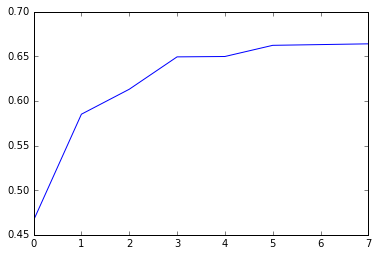

In [96]:
plt.plot(acc2+acc4)

In [102]:
w_alt = SimpleWeights(np.random.normal(scale=.5, size=21), 'test')
L_alt = []
av_L_alt = []
acc_alt = []
W = []
for i in range(10):
    w_alt, l_alt = train(train_data, w_alt, 0.001, 0.01)
    W.append(w_alt.asList[:])
    L_alt.append(l_alt)
    av_L3.append(sum(l_alt)/len(l_alt))
    acc_alt.append(test(test_data, w_alt))

100%|██████████| 2677/2677 [00:52<00:00, 51.35it/s]


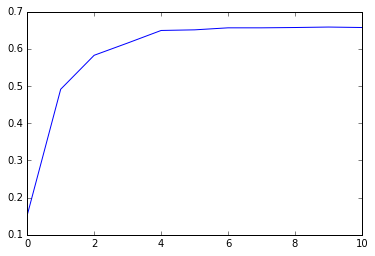

In [107]:
plt.plot(acc_alt)

In [104]:
w0 = SimpleWeights(np.random.normal(scale=.5, size=21), 'test')

In [105]:
a0 = test(test_data, w0)

100%|██████████| 2677/2677 [00:52<00:00, 51.48it/s]


In [106]:
acc_alt.insert(0, a0)